In [1]:
import os
import sys

os.chdir(os.path.dirname(sys.path[0]))

In [2]:
import logging
import time

import pandas as pd

log_file_name = 'run_logs/data_cleaning.log'
open(log_file_name, 'w').close()  # create empty logfile
logging.basicConfig(
    filename=log_file_name,
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s %(levelname)s: %(message)s',
    datefmt='%d-%m-%Y %H:%M:%S',
    )

START_TIME = time.time()

def get_td(current_time=None):
    if not current_time:
        current_time = time.time()
    return '{:.1f} s'.format(current_time-START_TIME)

logging.info(f"Start data preprocessing - {get_td()}")
raw_df = pd.read_csv(
    "wind/data/example_raw_data.csv",
    sep=';',
    index_col=0,
    low_memory=False)

logging.info(f"Raw dataset loaded - {get_td()}")
raw_df.head()

,Datum (Anlage),Zeit (Anlage),Ereignis,Error Number,Wind Speed (avg),Wind Speed (max),Wind Speed (min),Rotor Speed [rpm] (avg),Rotor Speed [rpm] (max),Rotor Speed [rpm] (min),...,Feature 73,Feature 74,Feature 75,Feature 76,Feature 77,Feature 78,Feature 79,Feature 80,Feature 81,Feature 82
0,01.01.18,00:00:00,NaN,NaN,"10,47",NaN,NaN,"12,00",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01.01.18,00:10:00,NaN,NaN,"11,20",NaN,NaN,"11,99",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01.01.18,00:20:00,NaN,NaN,"11,45",NaN,NaN,"11,99",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01.01.18,00:30:00,NaN,NaN,"10,99",NaN,NaN,"11,98",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01.01.18,00:40:00,NaN,NaN,"9,81",NaN,NaN,"12,03",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Dataset cleaning
We will:
* Replace missing values with np.nan
* Replace all ',' with '.'
* Drop empty columns
* Regex based conversion
* Column uniques count check
* Multicollinearity check
* Quantize datetimes
* Drop datetime duplicates
* Check datetime gaps

In [3]:
import numpy as np

# Replace missing values with np.nan
raw_df.fillna(np.nan, inplace=True)
logging.info(f"Replaced NaNs - {get_td()}")

In [4]:
# Replace all ',' by '.'
raw_df.replace(',', '.', regex=True, inplace=True)
logging.info(f"Replaced ',' with '.' - {get_td()}")

In [5]:
# Drop empty columns
raw_df.dropna(axis=1, inplace=True, how='all')
logging.info(f"Empty columns dropped - {get_td()}")

In [6]:
# Regex based conversion
import re

import numpy as np

fill_value = np.nan

# Define column types
column_dtypes = {
    "date": [
        'Datum (Anlage)',
    ],
    "time": [
        'Zeit (Anlage)',
    ],
    "float": [
        'Wind Speed (avg)',
        'Rotor Speed [rpm] (avg)',
        'Active Power (avg)',
        'Nacelle Position (avg)',
        'Generator Speed [rpm] (avg)',
        'Feature 0',
        'Feature 1',
        'Feature 2',
        'Feature 3',
        'Feature 4',
        'Feature 5',
        'Feature 6',
        'Feature 7',
        'Feature 8',
        'Feature 9',
        'Reactive Power (avg)',
        'Feature 13',
        'Feature 14',
        'Feature 15',
        'Feature 16',
        'Feature 17',
        'Feature 18',
        'Feature 19',
        'Feature 20',
        'Feature 21',
        'Feature 22',
        'Feature 23',
        'Feature 24',
        'Feature 25',
        'Feature 26',
        'Feature 27',
        'Feature 28',
        'Feature 29',
        'Feature 33',
        'Feature 34',
        'Feature 35',
        'Feature 36',
        'Feature 39',
        'Feature 41',
        'Feature 42',
        'Feature 43',
        'Feature 44',
        'Feature 45',
        'Feature 46',
        'Feature 47',
        'Feature 50',
        'Feature 51',
        'Feature 52',
        'Feature 53',
        'Feature 54',
        'Feature 55',
        'Feature 56',
        'Feature 57',
        'Feature 57',
        'Feature 58',
        'Feature 59',
        'Feature 60',
        'Feature 61',
        'Feature 62',
        'Feature 63',
        'Feature 82'
    ],
    "object": [
        'Ereignis'
        ]
}

def filter_by_regex(s:pd.Series, regex:re.Pattern, keep_matches:bool=True, debug:bool=False) -> pd.Series:
    "Filter a pandas series column according to a regex pattern."
    clean_uniques = []
    filtered_uniques = []
    for unique_value in s.unique():
        if isinstance(unique_value, float) and np.isnan(unique_value):
            filtered_uniques.append(unique_value)
            continue
        if keep_matches*bool(re.match(regex, str(unique_value))):
            clean_uniques.append(unique_value)
        else:
            filtered_uniques.append(unique_value)
    replaced = s.replace(filtered_uniques, fill_value)
    if debug:
        print(f"kept uniques: {clean_uniques}")
        print(f"filtered uniques: {filtered_uniques}")
        print(f'replaced {(s != replaced).sum()} total values')
    return replaced

def set_dtype(s:pd.Series, dtype:str) -> pd.Series:
    if dtype == 'date':
        s = pd.to_datetime(s, format = '%d.%m.%y').dt.date
    elif dtype == 'time':
        s = pd.to_datetime(s, format = '%H:%M:%S').dt.time
    else:
        s = s.astype(dtype)
    return s

# Here set regex validators for data entry per dtype
valid_patterns = {
    "float": re.compile(r'^-?\d*(\.\d*)?$'),
    "date": re.compile(r'^(0[1-9]|[1-2][0-9]|3[0-1])\.(0[1-9]|1[0-2])\.([0-9]{2})$'),
    "time": re.compile(r'^([0-1][0-9]|2[0-3]):([0-5][0-9]):[0-9]{2}$'),
    "int": re.compile(r'^-?\d+$'),
    "object": re.compile(r'.+'),
}

default_type = 'float'
debug_cols = [
    ]

# Filter values
wind_df = raw_df.copy(deep=True)
for col in wind_df.columns:
    col_type = None
    for column_type, type_columns in column_dtypes.items():
        if col in type_columns:
            col_type = column_type
            break
    if (is_debug_col := (col in debug_cols) or (not col_type)):
        if not col_type:
            print(f"'{col}' type not set -> {default_type}")
            col_type = default_type
        else:
            print(f"'{col}' - {col_type}")
    wind_df[col] = filter_by_regex(wind_df[col], valid_patterns[column_type], debug=is_debug_col)
    wind_df[col] = set_dtype(wind_df[col], column_type)
    if is_debug_col:
        print(list(wind_df[col].unique())[:5], wind_df[col].loc[wind_df[col].notna()].head(3), sep='\n')
        time.sleep(15)
logging.info(f"Regex based conversion - {get_td()}")

In [7]:
# Column uniques count check
mask_feats = []
cat_feats = []
uniques_threshold = 5
for col in wind_df.columns:
    if len((uniques:=set(wind_df[col].unique())))<=uniques_threshold:
        for item in uniques.copy():
            if isinstance(item, float) and np.isnan(item):
                uniques.discard(item)
        if len(uniques)==1:
            print(f"\nColumn {wind_df[col].value_counts(dropna=False)}\n\nis possibly a mask feature")
            mask_feats.append(col)
        else:
            print(f"\nColumn {wind_df[col].value_counts(dropna=False)}\n\nis possibly a categorical feature")
            cat_feats.append(col)
            
logging.info(f"Column uniques count checked - {get_td()}")


Column Ereignis
NaN                                362977
Leistungsbetrieb (10m)               4327
keine Leistung trotz Wind (10m)       190
Name: count, dtype: int64

is possibly a categorical feature

Column Feature 58
NaN    244861
0.0    122633
Name: count, dtype: int64

is possibly a mask feature

Column Feature 60
NaN    244861
0.0    122633
Name: count, dtype: int64

is possibly a mask feature

Column Feature 82
NaN    235991
1.0    131503
Name: count, dtype: int64

is possibly a mask feature


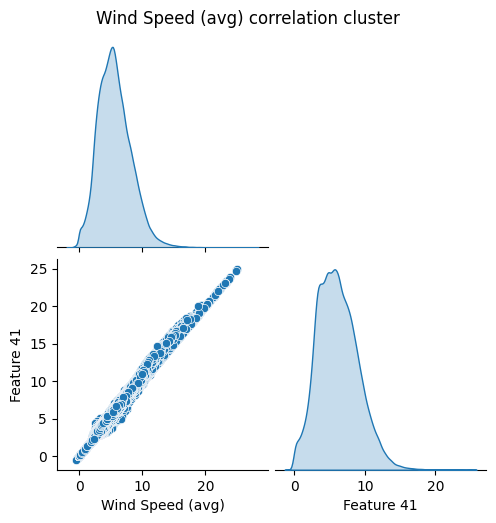

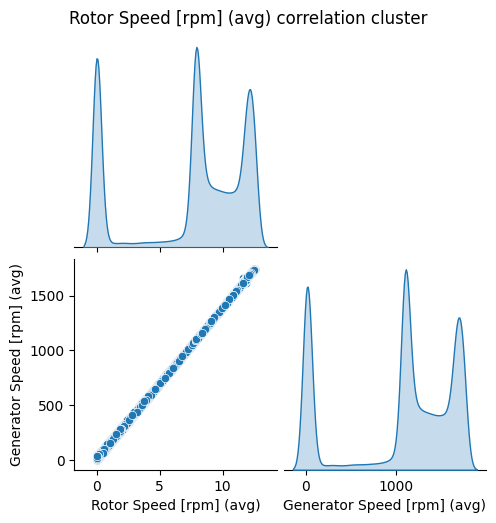

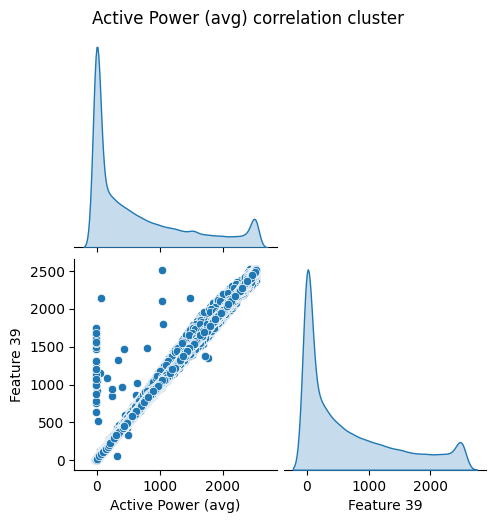

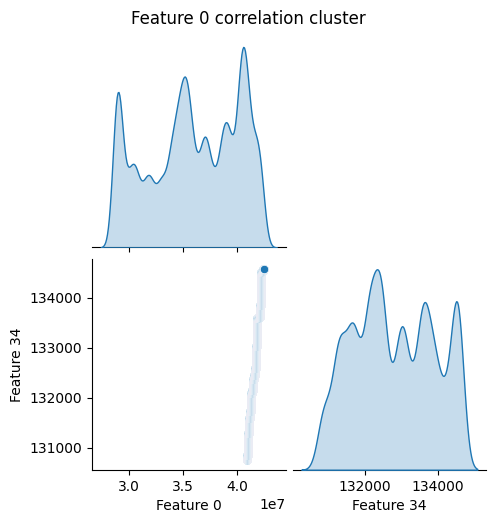

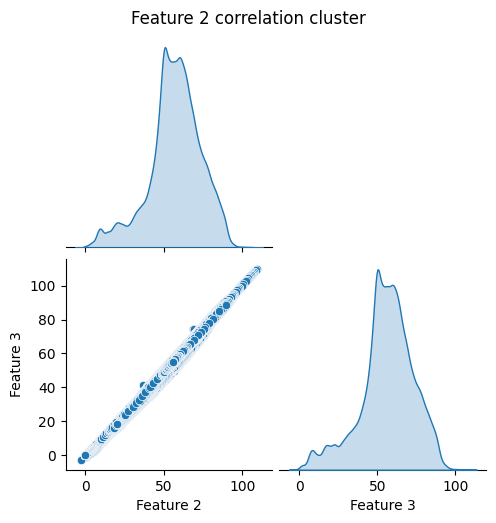

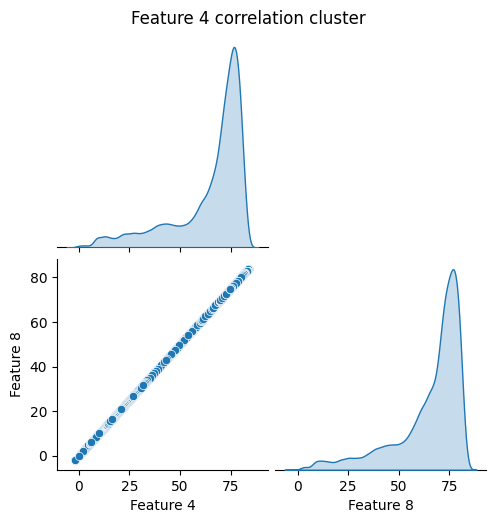

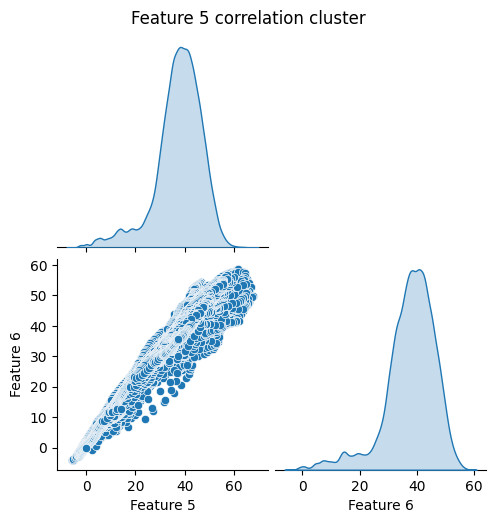

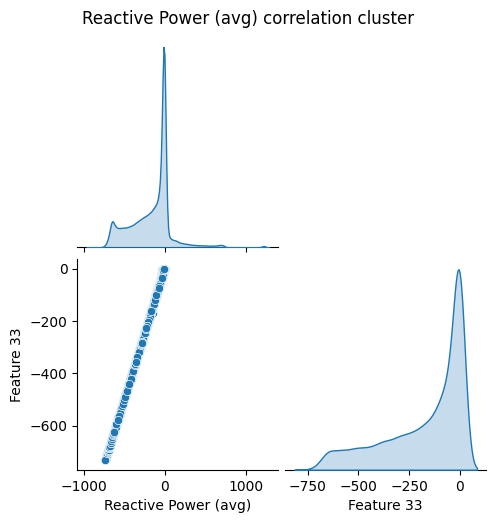

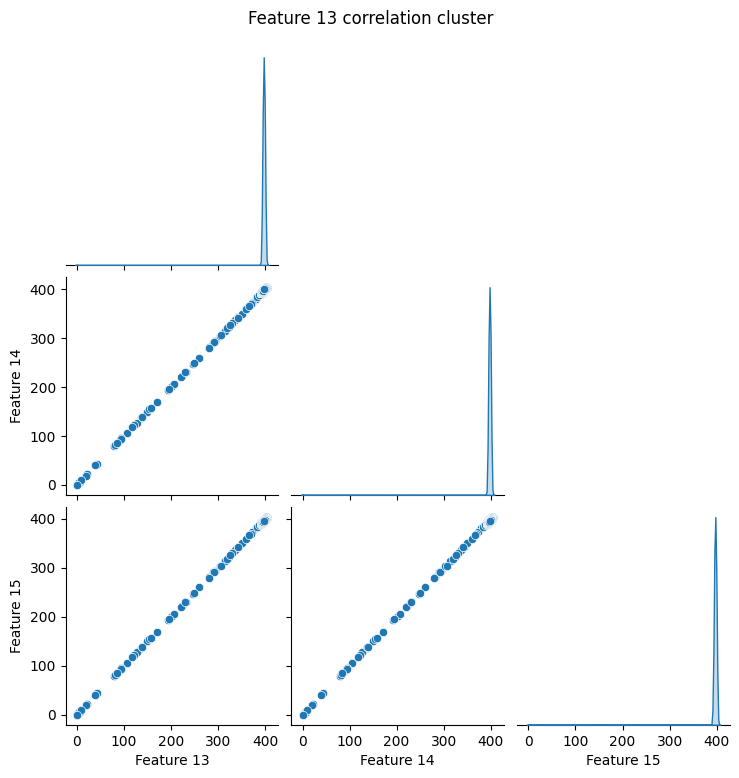

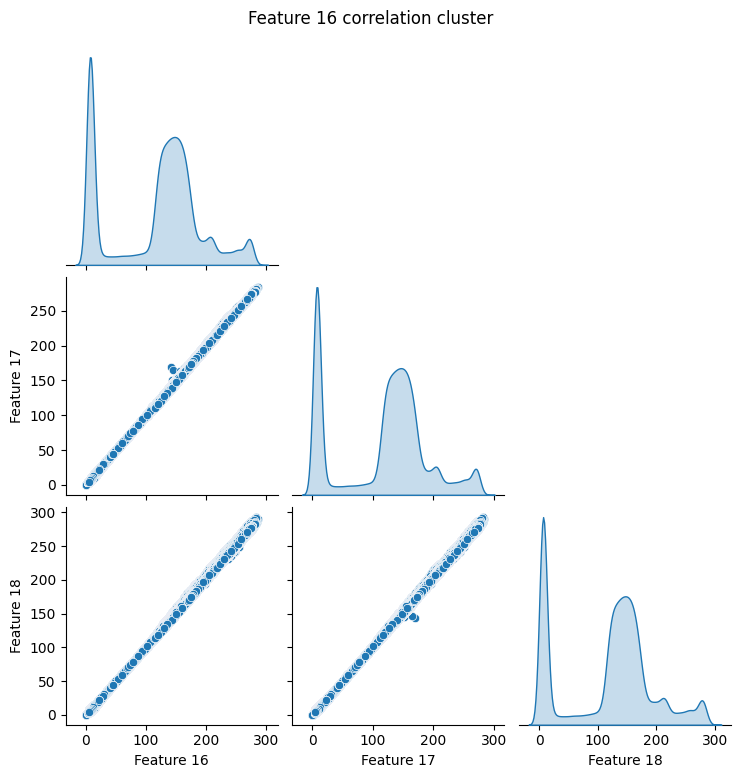

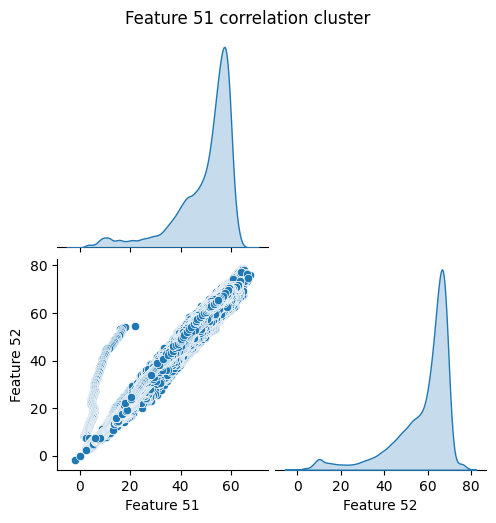

In [8]:
# Multicollinearity check
from phik import phik_matrix
import seaborn as sns

corr_threshold=.975
min_nunique=1000

corr_cols = [c for c in column_dtypes['float'] if wind_df[c].nunique()>min_nunique]
corr_df = pd.DataFrame.copy(wind_df[corr_cols].reset_index(drop=True), deep=True)
corr = phik_matrix(corr_df, verbose=False)

seen = []
plot_graphs=True
for i, col_i in enumerate(corr.index):
    if col_i in seen:
        continue
    if plot_graphs and not (collinear:=corr.iloc[i,i+1:].loc[corr[col_i]>corr_threshold]).empty:
        g = sns.pairplot(corr_df, vars=[col_i] + list(collinear.index), diag_kind='kde', corner=True)
        g.fig.suptitle(f"{col_i} correlation cluster", y=1.03, fontsize=12)
        seen += list(collinear.index)

logging.info(f"Multicollinearity checked - {get_td()}")

According to the correlation cluster plots, the explaining power of some features is rendered low due to collinearity with other features.

We can observe:
* Rotor speed is very collinear with generator speed which is expected since these are connected components. For each turn of the rotator there are more than 100 turns of the generator.
* Feature 4 and 8 have an almost perfectly linear relationship
* Features 13, 14, 15 have an almost perfectly linear relationship
* Features 18 and 16 have an almost perfectly linear relationship

If later we decide to mitigate potential negative effects of multicollinearity, we can consider dropping up to all but one variable from each of these clusters.

In [9]:
# Quantize datetimes
import datetime as dt

def combine_datetime(row: pd.Series):
    return dt.datetime.combine(
        row['Datum (Anlage)'], row['Zeit (Anlage)']
        )

def split_datetime(col: pd.Series):
    return pd.DataFrame({
        'Datum (Anlage)': col.apply(pd.Timestamp.date),
        'Zeit (Anlage)': col.apply(pd.Timestamp.time)})

wind_df['datetime'] = wind_df.apply(combine_datetime, axis=1)

# Quantize datetime
timedeltas = pd.Series(wind_df.datetime-wind_df.datetime.shift(), name='timedeltas before')
print(timedeltas.value_counts())
default_td = timedeltas.mode()[0].seconds/60  # in minutes

print(f"Rounding datetimes to nearest {default_td} minute step")
wind_df['datetime'] = wind_df['datetime'].round(f'{default_td}min')
wind_df[['Datum (Anlage)', 'Zeit (Anlage)']] = split_datetime(wind_df.datetime)

logging.info(f"Quantized datetimes - {get_td()}")

timedeltas before
0 days 00:10:00         367467
0 days 01:10:00              7
-1 days +23:10:00            7
366 days 00:00:00            2
0 days 00:10:01              1
0 days 00:09:59              1
-2556 days +00:00:00         1
0 days 00:10:05              1
0 days 00:09:55              1
1 days 00:00:00              1
0 days 00:09:33              1
0 days 00:00:27              1
0 days 00:11:02              1
0 days 00:08:58              1
Name: count, dtype: int64
Rounding datetimes to nearest 10.0 minute step


In [10]:
# Sort by datetime
wind_df.sort_values(['datetime'], inplace=True)
logging.info(f"Sorted by datetime - {get_td()}")

In [11]:
# Drop datetime duplicates
dups = wind_df.duplicated(subset=['datetime'])
print(f"Found {dups.sum()} duplicated datetimes. Keeping the first record of each duplicate.")
wind_df = wind_df.loc[~dups]
wind_df.reset_index(drop=True, inplace=True)
logging.info(f"Droped datetime duplicates - {get_td()}")

Found 43 duplicated datetimes. Keeping the first record of each duplicate.


The following missing data events were detected:
             is_missing  week_day  downtime_hours
2015-03-29    4.166667    Sunday               1
2016-03-27    4.166667    Sunday               1
2016-12-31   99.305556  Saturday              24
2017-03-26    4.166667    Sunday               1
2017-12-31   99.305556    Sunday              24
2018-03-25    4.166667    Sunday               1
2018-12-31   99.305556    Monday              24
2019-03-31    4.166667    Sunday               1
2019-12-31   99.305556   Tuesday              24
2020-03-29    4.166667    Sunday               1
2021-03-28    4.166667    Sunday               1


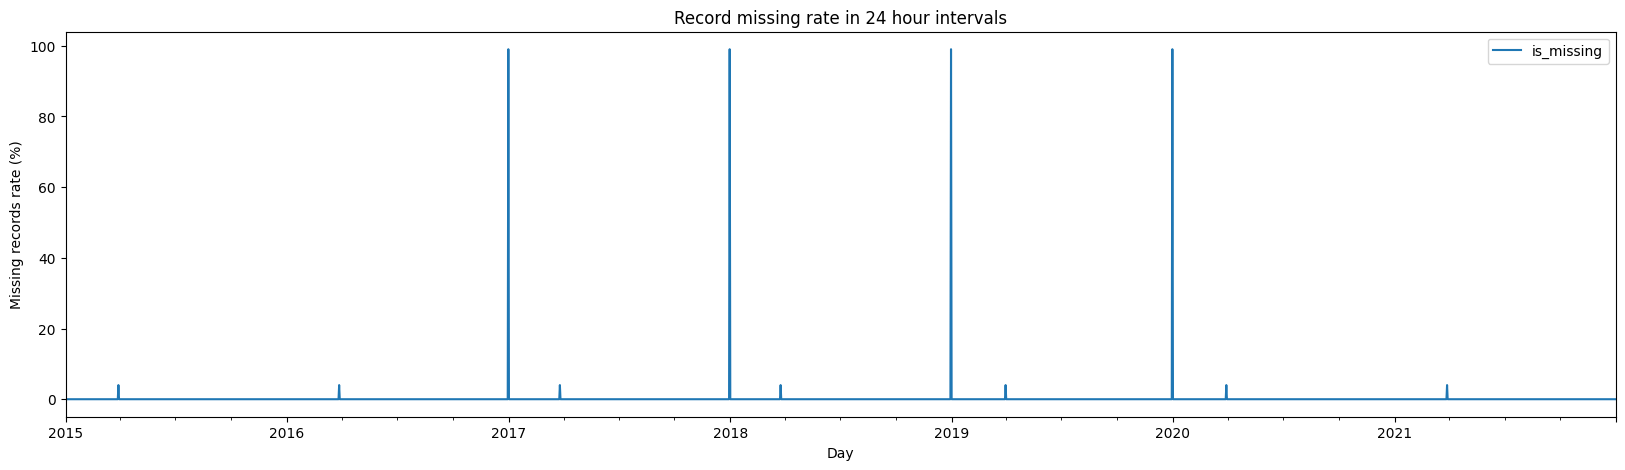

In [21]:
# Check datetime missingness
time_ranges = pd.DataFrame(index=pd.date_range(start=wind_df.datetime.iloc[0], end=wind_df.datetime.iloc[-1], freq='10T'))
time_ranges['is_missing'] = False
time_ranges['is_missing'].loc[~time_ranges.index.isin(wind_df.datetime.values)] = True

bin_size = 24 # in hours
bin_timedelta = pd.Timedelta(f"{bin_size}h").value
group_f = lambda x: pd.to_datetime((x.value//bin_timedelta)*bin_timedelta)
groups = time_ranges.groupby(time_ranges.index.to_series().apply(group_f))
bin_miss_rate = groups.mean()*100

ax = bin_miss_rate.astype(int).plot(figsize=(20,5), title=f'Record missing rate in {bin_size} hour intervals')
ax.set_xlabel('Day')
ax.set_ylabel('Missing records rate (%)')
ax.get_figure()

flag_pct_threshold = 1  # Missing rate percentage above this value is flagged as an event
events = pd.DataFrame.copy(bin_miss_rate.loc[bin_miss_rate.values>flag_pct_threshold], deep=True)
events['week_day'] = list(map(lambda x: x.strftime('%A'), events.index))
events['downtime_hours'] = (events['is_missing']/100*24).round().astype(int)
print("The following missing data events were detected:\n", events)
logging.info(f"datetime missingness checked - {get_td()}")

There seems to be a regular 1 hour down time in the last Sunday of every March. This is probably scheduled maintenance.

There is a full day down time in the last day of the years 2016 to 2020.

In [ ]:
# Store clean dataset
wind_df.to_csv(
    "wind/data/example_clean.csv"
    )
logging.info(f"clean dataset saved - {get_td()}")